In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
import tqdm
import math

In [2]:
# CI function
def CI(data,alpha):
    sample_mean=np.mean(data) # data is a list!
    sample_sigma=np.std(data)
    critical_point = norm.ppf(1-alpha/2)
    LB=sample_mean-critical_point*sample_sigma/np.sqrt(len(data))
    UB=sample_mean+critical_point*sample_sigma/np.sqrt(len(data))
    return LB,UB

In [25]:
'''
Step 1: Simulate interest rate (discount the cash flow) → Vasicek Model
Step 2: prepayment model (Get CPR) → Richard and Roll(1989)
Step 3: MBS pricing
'''
# parameters
kappa=2
theta=0.025
sigma=0.1
r0=0.025
size=10000

N=252 # Need to revise 
T=1
h=T/N

# Generate interest rate 
r=np.ones((1,size))*r0
zero=np.zeros(size)
Z1=np.random.normal(0,1,(N,size))
for i in tqdm.tqdm(range(N)):
    m=r[i,:]+kappa*(theta-np.max([r[i,:],zero],axis=0))*h+sigma*np.sqrt(np.max([r[i,:],zero],axis=0))*np.sqrt(h)*Z1[i,:]
    r=np.append(r,[m],axis=0)

100%|██████████| 252/252 [00:01<00:00, 214.79it/s]


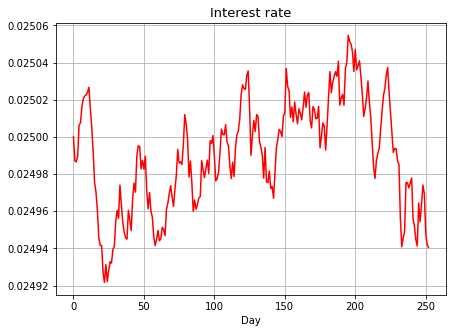

In [34]:
# Plot interest rate
test=np.mean(r,axis=1)
plt.figure(figsize=(7,5))
plt.plot(test,color='red')
plt.title('Interest rate',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

In [71]:
# Prepayment Model

WAC=np.ones((N,size))*0.05 # Need to revise
B0=1000000
B=np.ones((1,size))*B0 # Need to revise
for i in range(N-1):
    n=B[-1,:]*0.8
    B=np.append(B,[n],axis=0)

# Refinancing incentive
max_cpr=0.5
min_cpr=0
mid_diff_cpr=0.02
mid_max_slope=0.06/0.001
a=(max_cpr+min_cpr)/2
b=100*(max_cpr-a)/(np.pi/2)
d=mid_max_slope/b
c=-d*mid_diff_cpr
RI=a+b*np.arctan(c+d*(WAC-r[1:,:])) # Formulas from Davidson/Herskovitz (1996).

# Seasoning multiplier
t=np.ones((1,size))
for i in range(N-1):
    o=t[-1,:]+1
    t=np.append(t,[o],axis=0)
Age=np.min([t/30,np.ones((N,size))],axis=0)

# Monthly multiplier
temp=np.array([[0.94,0.76,0.74,0.95,0.98,0.92,0.98,1.10,1.18,1.22,1.23,0.98]])
testf=np.ones((1,N))
temp1=[]
for i in range(len(testf[0])):
    index=math.floor(i/21)
    temp2=testf[0][index]*temp[0][index]
    temp1=np.append(temp1,temp2)
MM=np.ones((N,size))*(np.array([temp1]).T)

# Burnout multiplier
BM=0.3+0.7*(B/B0)

# CPR
CPR=np.maximum(RI*Age*MM*BM,np.zeros((N,size)))

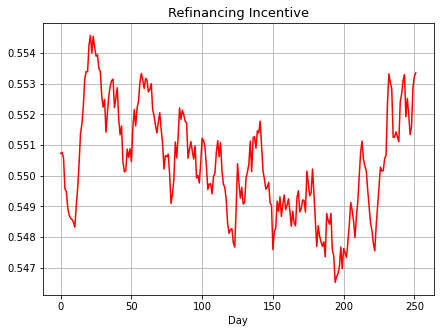

In [83]:
# Plot RI
RI_mean=np.mean(RI,axis=1)
plt.figure(figsize=(7,5))
plt.plot(RI_mean,color='red')
plt.title('Refinancing Incentive',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

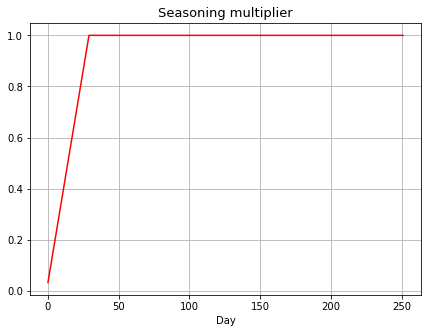

In [84]:
# Plot Seasoning multiplier
Age_mean=np.mean(Age,axis=1)
plt.figure(figsize=(7,5))
plt.plot(Age_mean,color='red')
plt.title('Seasoning multiplier',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

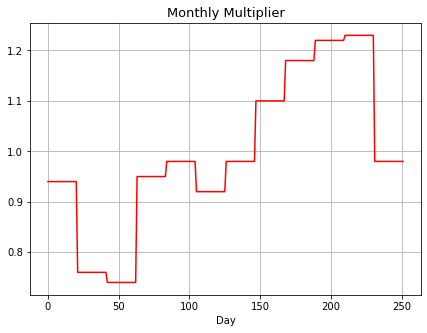

In [85]:
# Plot Monthly multiplier
MM_mean=np.mean(MM,axis=1)
plt.figure(figsize=(7,5))
plt.plot(MM_mean,color='red')
plt.title('Monthly Multiplier',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

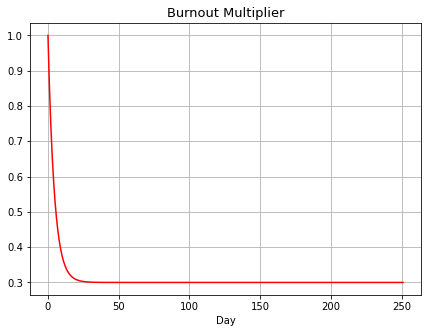

In [86]:
# Plot Burnout multiplier
BM_mean=np.mean(BM,axis=1)
plt.figure(figsize=(7,5))
plt.plot(BM_mean,color='red')
plt.title('Burnout Multiplier',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

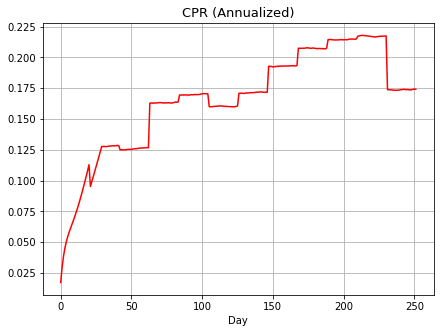

In [87]:
# Plot CPR
CPR_mean=np.mean(CPR,axis=1)
plt.figure(figsize=(7,5))
plt.plot(CPR_mean,color='red')
plt.title('CPR (Annualized)',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

In [88]:
# MP(t) is the scheduled mortgage payment for period t
WAM=np.ones((1,size))*300
for i in range(N-1):
    p=WAM[-1,:]-1
    WAM=np.append(WAM,[p],axis=0)
MP=B*((WAC/12)/(1-np.power(1+WAC/12,-WAM)))

# IP(t) is the Interest payment for period t
IP=B*WAC/12

# PP(t) is the principal prepayment for period t
SMM=1-np.power(1-CPR,1/12)
SP=MP-IP
PP=SMM*(B-SP)

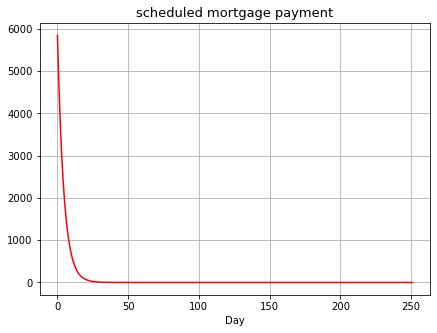

In [93]:
# Plot scheduled mortgage payment for period t
MP_mean=np.mean(MP,axis=1)
plt.figure(figsize=(7,5))
plt.plot(MP_mean,color='red')
plt.title('scheduled mortgage payment',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

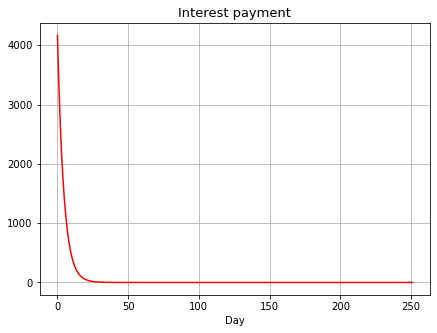

In [94]:
# Plot Interest payment
IP_mean=np.mean(IP,axis=1)
plt.figure(figsize=(7,5))
plt.plot(IP_mean,color='red')
plt.title('Interest payment',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

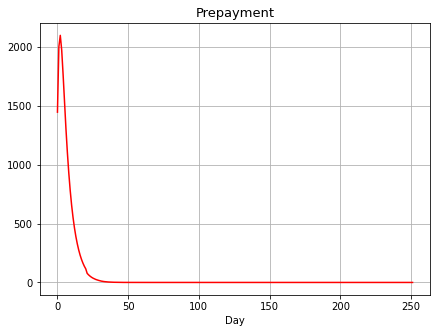

In [92]:
# Plot Prepayment
PP_mean=np.mean(PP,axis=1)
plt.figure(figsize=(7,5))
plt.plot(PP_mean,color='red')
plt.title('Prepayment',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

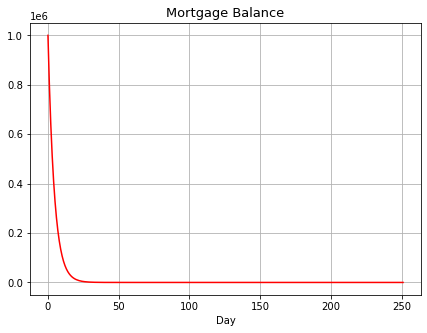

In [91]:
# Plot Mortgage Balance 
B_mean=np.mean(B,axis=1)
plt.figure(figsize=(7,5))
plt.plot(B_mean,color='red')
plt.title('Mortgage Balance',fontsize=13)
plt.xlabel('Day',fontsize = 10)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.show()

In [ ]:
# MBS pricing